In [1]:
import wandb
api = wandb.Api()


In [2]:
# Import seaborn
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
group_name = "Evaluate ground-truth accuracy on grid-size-5 (dirichlet: 10)"
# group_name = "Sweep delta and seeds with Q output and walls."

In [20]:
import pandas as pd
runs = api.runs("rldl/icvi", {"$and": [{"group": group_name}]})


def generate_dfs():
    for run in runs:
        print(run.name)
        history = pd.DataFrame(run.history())
        history["seed"] = run.config["seed"]
        history["algorithm"] = run.config["config_name"]
        print(run.config["config_name"])
        yield history

orig = pd.concat(list(generate_dfs()))
orig.columns
orig.algorithm.unique()

trainable_e392b_00000
delta-2
trainable_e392b_00001
delta-2
trainable_80f25_00000
grid-size-5
trainable_80f25_00001
grid-size-5
trainable_71b1e_00000
delta-2
trainable_71b1e_00001
delta-2
trainable_53ed8_00000
baseline
trainable_53ed8_00001
baseline


/var/folders/mr/d6vzg_f16dn1wl4_2bcx6l9w0000gn/T/ipykernel_21514/4100705847.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  orig = pd.concat(list(generate_dfs()))


array(['delta-2', 'grid-size-5', 'baseline'], dtype=object)

In [25]:
df = orig.rename(columns={"_step": "step", 'train/(ground-truth final)/rmse': "root mean-square error", "delta": "$\delta$"})

df['algorithm'] = df['algorithm'].replace({
    "delta-2": "$\delta=2$",
    "baseline": "$\delta=\delta_\max$",
    "grid-size-5": "$\delta=1$",
})

df = df[df["step"] <= 150_000]

b = 5000
df['step'] = (df['step'] // b) * b
df = df.reset_index()
df[["step", "root mean-square error", "algorithm"]]

/var/folders/mr/d6vzg_f16dn1wl4_2bcx6l9w0000gn/T/ipykernel_21514/1790986724.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['step'] = (df['step'] // b) * b


,step,root mean-square error,algorithm
0,0,NaN,$\delta=2$
1,0,NaN,$\delta=2$
2,0,NaN,$\delta=2$
3,0,NaN,$\delta=2$
4,0,NaN,$\delta=2$
...,...,...,...
52146,145000,NaN,$\delta=\delta_\max$
52147,145000,0.215939,$\delta=\delta_\max$
52148,145000,NaN,$\delta=\delta_\max$
52149,145000,NaN,$\delta=\delta_\max$


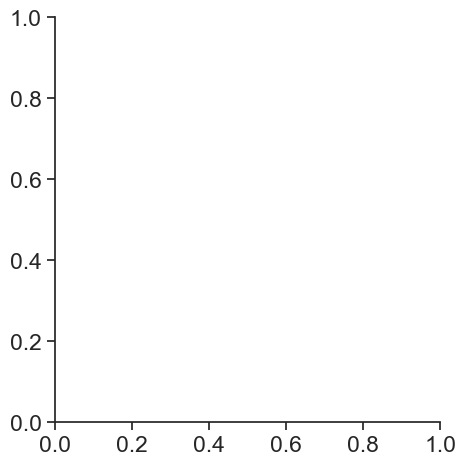

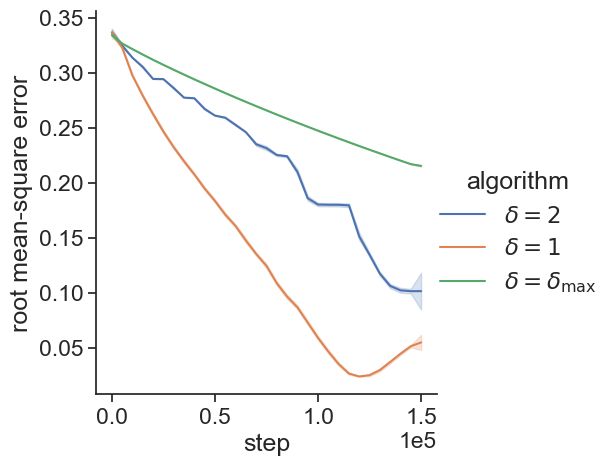

In [26]:
import seaborn as sns
sns.reset_defaults()
sns.set(font_scale=1.5)
sns.set_style('ticks')

g = sns.relplot(data=df, kind="line", x="step", y="root mean-square error", hue="algorithm")
# g.set(yscale="log")
for ax in g.axes.flatten():
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()